# NFL Model Backtesting (2025 Holdout)

This notebook implements a rigorous backtesting strategy to validate model performance. 
Instead of a random train/test split, we use a time-based split:
- **Training Data**: Seasons 2020-2024
- **Testing Data**: Season 2025 (Weeks 1-11)

This simulates the real-world scenario of training on historical data to predict the current season.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, brier_score_loss, log_loss
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import lightgbm as lgb
import sys
import os

# Add src to path for imports
sys.path.append(os.path.abspath(os.path.join('..')))

from src.pipeline.train_models import build_training_dataset, compute_season_sample_weights
from src.models.link_function import fit_link_function, apply_link_function

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 1. Data Loading & Splitting
We load data for all available seasons (2020-2025) and then split based on the season year.

In [2]:
# Define seasons
TRAIN_SEASONS = [2020, 2021, 2022, 2023, 2024]
TEST_SEASONS = [2025]
ALL_SEASONS = TRAIN_SEASONS + TEST_SEASONS

print(f"Loading data for seasons: {ALL_SEASONS}")

# Build dataset (this handles feature engineering internally)
# We set 'current_season' to 2025 to ensure we get the latest data structure
df = build_training_dataset(seasons=ALL_SEASONS, league='NFL')

print(f"Total games loaded: {len(df)}")
print(f"Seasons found: {df['season'].unique()}")

Loading data for seasons: [2020, 2021, 2022, 2023, 2024, 2025]
Total games loaded: 1573
Seasons found: [2020 2021 2022 2023 2024 2025]


In [3]:
# Create Train/Test Split
train_df = df[df['season'].isin(TRAIN_SEASONS)].copy()
test_df = df[df['season'].isin(TEST_SEASONS)].copy()

print(f"Training Set (2020-2024): {len(train_df)} games")
print(f"Testing Set (2025): {len(test_df)} games")

# Verify no data leakage
assert not train_df['season'].isin(TEST_SEASONS).any(), "Test data found in training set!"

Training Set (2020-2024): 1408 games
Testing Set (2025): 165 games


## 2. Model Training
We train two models:
1. **Spread Model**: Predicts the point margin (`home_score - away_score`).
2. **Win Probability Model**: Predicts `home_win` (binary), using the predicted spread as a feature.

In [10]:
# Define features (based on nfl_eda.ipynb findings)
feature_cols = [
    "rest_home", "rest_away", "b2b_home", "b2b_away",
    "opp_strength_differential", "team_strength_win_pct",
    "team_strength_point_diff",
    # EPA rolling windows
    "form_epa_off_diff_3", "form_epa_off_diff_5", "form_epa_off_diff_10",
    "form_epa_def_diff_3", "form_epa_def_diff_5", "form_epa_def_diff_10",
    # Interaction columns (if present)
    "rest_differential", "win_pct_differential"
]

# Filter to available columns
feature_cols = [c for c in feature_cols if c in train_df.columns]
print(f"Training with {len(feature_cols)} features: {feature_cols}")

# Prepare X and y
X_train = train_df[feature_cols].fillna(0) # Simple imputation for now
y_train_spread = train_df['margin']
y_train_win = train_df['home_win'].astype(int)

X_test = test_df[feature_cols].fillna(0)
y_test_spread = test_df['margin']
y_test_win = test_df['home_win'].astype(int)

# Sample Weights (give more weight to recent seasons in training)
weights = compute_season_sample_weights(train_df, growth_per_year=1.1)

Training with 13 features: ['rest_home', 'rest_away', 'b2b_home', 'b2b_away', 'opp_strength_differential', 'form_epa_off_diff_3', 'form_epa_off_diff_5', 'form_epa_off_diff_10', 'form_epa_def_diff_3', 'form_epa_def_diff_5', 'form_epa_def_diff_10', 'rest_differential', 'win_pct_differential']


In [22]:
# --- 1️⃣  Train Spread Model (try RandomForestRegressor) ---
print("Training Spread Model (RandomForestRegressor)…")
from sklearn.ensemble import RandomForestRegressor

# you can keep the same hyper‑params (they’ll be ignored by RF where not applicable)
spread_model = RandomForestRegressor(
        n_estimators=300,          # more trees → usually a bit better
        max_depth=None,
        random_state=42,
        n_jobs=-1)
spread_model.fit(X_train, y_train_spread, sample_weight=weights)

# Predict on test set
test_df['pred_spread'] = spread_model.predict(X_test)

# Evaluate
mae  = mean_absolute_error(y_test_spread, test_df['pred_spread'])
rmse = np.sqrt(mean_squared_error(y_test_spread, test_df['pred_spread']))
print(f"Spread Model Results (2025): MAE={mae:.2f}, RMSE={rmse:.2f}")

Training Spread Model (RandomForestRegressor)…
Spread Model Results (2025): MAE=10.68, RMSE=13.83


In [23]:
# --- 2️⃣  Train Win‑Probability Model (LogisticRegression + calibration) ---
print("Training Win Probability Model (LogisticRegression + CalibratedClassifier)…")

from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

# Add the predicted spread as a feature (re‑predict on train for simplicity)
train_df['pred_spread'] = spread_model.predict(X_train)

X_train_win = X_train.copy()
X_train_win['pred_spread'] = train_df['pred_spread']

X_test_win = X_test.copy()
X_test_win['pred_spread'] = test_df['pred_spread']

# Base logistic regression (no regularisation needed for a quick test)
base_clf = LogisticRegression(max_iter=1000, solver='lbfgs')

# Calibrate with 5‑fold CV (sigmoid = Platt scaling)
# NOTE: the correct keyword is **estimator**, not **base_estimator**
win_model = CalibratedClassifierCV(estimator=base_clf,
                                   cv=5,
                                   method='sigmoid')
win_model.fit(X_train_win, y_train_win, sample_weight=weights)

# Predict probabilities
test_df['pred_win_prob'] = win_model.predict_proba(X_test_win)[:, 1]

# Evaluate
acc   = accuracy_score(y_test_win, test_df['pred_win_prob'] > 0.5)
brier = brier_score_loss(y_test_win, test_df['pred_win_prob'])
ll    = log_loss(y_test_win, test_df['pred_win_prob'])

print(f"Win Prob Model Results (2025): Accuracy={acc:.2%}, "
      f"Brier={brier:.4f}, LogLoss={ll:.4f}")

Training Win Probability Model (LogisticRegression + CalibratedClassifier)…
Win Prob Model Results (2025): Accuracy=59.39%, Brier=0.3280, LogLoss=1.3504


## 3. Analysis & Visualization

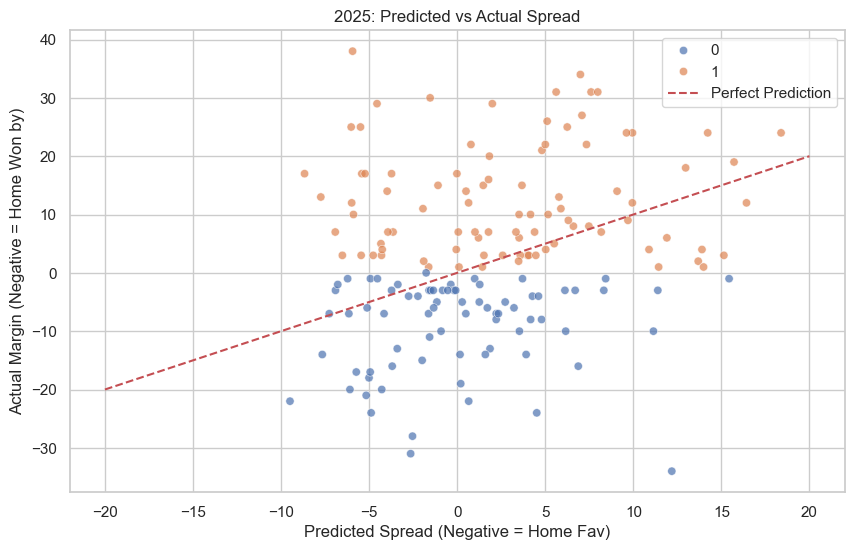

In [24]:
# Plot Actual vs Predicted Spread
plt.figure(figsize=(10, 6))
sns.scatterplot(data=test_df, x='pred_spread', y='margin', hue='home_win', alpha=0.7)
plt.plot([-20, 20], [-20, 20], 'r--', label='Perfect Prediction')
plt.title("2025: Predicted vs Actual Spread")
plt.xlabel("Predicted Spread (Negative = Home Fav)")
plt.ylabel("Actual Margin (Negative = Home Won by)")
plt.legend()
plt.show()

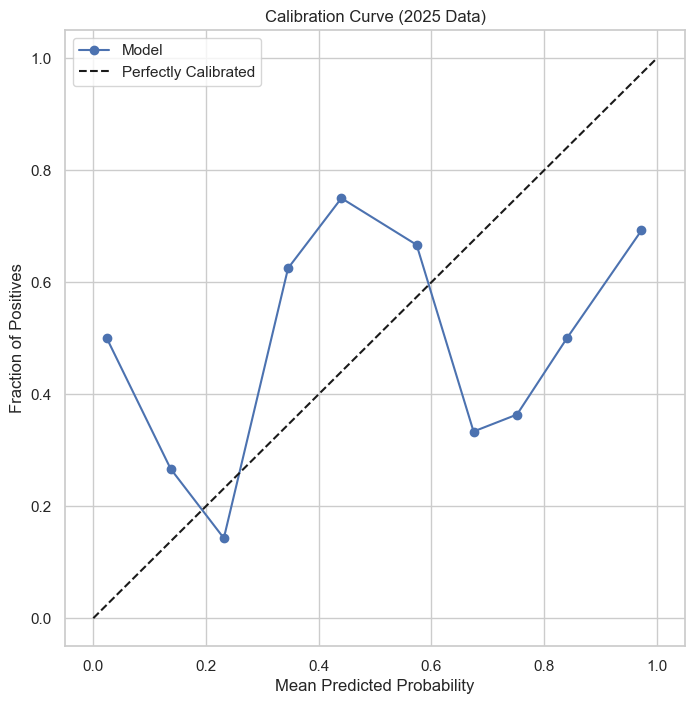

In [25]:
# Calibration Curve
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test_win, test_df['pred_win_prob'], n_bins=10)

plt.figure(figsize=(8, 8))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.title("Calibration Curve (2025 Data)")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.show()

In [26]:
# Betting Simulation (Simple)
# Assume we bet on Home if pred_win_prob > 0.6, Away if < 0.4
test_df['bet_home'] = test_df['pred_win_prob'] > 0.6
test_df['bet_away'] = test_df['pred_win_prob'] < 0.4

test_df['won_bet'] = np.where(
    test_df['bet_home'], test_df['home_win'],
    np.where(test_df['bet_away'], ~test_df['home_win'], np.nan)
)

bets_made = test_df.dropna(subset=['won_bet'])
win_rate = bets_made['won_bet'].mean()

print(f"Simple Betting Simulation (Threshold > 60% confidence):")
print(f"Bets Placed: {len(bets_made)} / {len(test_df)}")
print(f"Win Rate: {win_rate:.2%}")

Simple Betting Simulation (Threshold > 60% confidence):
Bets Placed: 155 / 165
Win Rate: -30.32%
